#Insurance claim prdiction for buildings

##Projet Overview
Insurance companies need to accurately assess the risk associated with insuring buildings. This project entails building a predictive algorithm to estimate the probability that a bulding will have "at least one insurance clam" during an insured period, based on its characteristics.

##Objective
Perform thorough data cleaning and preprocessing. Explore and extract meaningful insights through EDA. Build and compare multiple ML algorithms . Evaluate model performance.

##Target variable
"Claim"
"1": buildng has at least one insurance claim
"0": buiding has no insurance claim



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

import warnings
warnings.filterwarnings("ignore")


# Initial data overview

In [3]:
train_df = pd.read_csv ("/content/sample_data/data_project/Train_data.csv")
desc_df = pd.read_csv ("/content/sample_data/data_project/Variable Description.csv")

train_df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [4]:
print("Dataset Shape:", train_df.shape)
train_df.info()

Dataset Shape: (7160, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.3+ KB


In [5]:
train_df.describe().T


,count,mean,std,min,25%,50%,75%,max
YearOfObservation,7160.0,2013.669553,1.383769,2012.0,2012.000000,2013.0,2015.00,2016.0
Insured_Period,7160.0,0.909758,0.239756,0.0,0.997268,1.0,1.00,1.0
Residential,7160.0,0.305447,0.460629,0.0,0.000000,0.0,1.00,1.0
Building Dimension,7054.0,1883.727530,2278.157745,1.0,528.000000,1083.0,2289.75,20940.0
Building_Type,7160.0,2.186034,0.940632,1.0,2.000000,2.0,3.00,4.0
Date_of_Occupancy,6652.0,1964.456404,36.002014,1545.0,1960.000000,1970.0,1980.00,2016.0
Claim,7160.0,0.228212,0.419709,0.0,0.000000,0.0,0.00,1.0


In [6]:
## Missing Values Analysis
train_df.isna().sum()


,0
Customer Id,0
YearOfObservation,0
Insured_Period,0
Residential,0
Building_Painted,0
Building_Fenced,0
Garden,7
Settlement,0
Building Dimension,106
Building_Type,0


## Data Cleaning and Preprocessing
Addresses data quality issues such as incorrect data types, missing values, and irrelevant features.


In [7]:
# check Duplicates
train_df.duplicated().sum()

np.int64(0)

In [8]:
# Column data types
cat_cols = train_df.select_dtypes(include=['object']).columns
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)

Categorical Columns: Index(['Customer Id', 'Building_Painted', 'Building_Fenced', 'Garden',
       'Settlement', 'NumberOfWindows', 'Geo_Code'],
      dtype='object')
Numerical Columns: Index(['YearOfObservation', 'Insured_Period', 'Residential',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy', 'Claim'],
      dtype='object')


In [9]:
# Count unique values in categorical column
for col in cat_cols:
    print(col, train_df[col].nunique())

Customer Id 7160
Building_Painted 2
Building_Fenced 2
Garden 2
Settlement 2
NumberOfWindows 11
Geo_Code 1307


In [10]:

## Fill missing values
# Fill Garden with mode
train_df['Garden'].fillna(train_df['Garden'].mode()[0], inplace=True)

# Fill numerical columns with median
train_df['Building Dimension'].fillna(train_df['Building Dimension'].median(), inplace=True)
train_df['Date_of_Occupancy'].fillna(train_df['Date_of_Occupancy'].median(), inplace=True)

# Fill Geo_Code missing values
train_df['Geo_Code'].fillna('Unknown', inplace=True)


# Drop identifier
train_df.drop(columns=['Customer Id'], inplace=True)



In [15]:
import numpy as np

# 1. Replace the weird "   ." with NaN (Standard missing value)
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace('   .', np.nan)

# 2. Replace ">=10" with the number 10
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace('>=10', 10)

# 3. Convert the column to Float (Decimal Number)
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].astype(float)

# 4. Fill the missing values (NaN) with the Median (Middle number)
# We use Median because it is safer for "counts" than Mean
train_df['NumberOfWindows'].fillna(train_df['NumberOfWindows'].median(), inplace=True)

# VERIFICATION
print("Unique Values in NumberOfWindows:")
print(train_df['NumberOfWindows'].unique())
print("\nColumn Type:")
print(train_df['NumberOfWindows'].dtype)

Unique Values in NumberOfWindows:
[ 4.  3.  2.  5. 10.  6.  7.  9.  8.  1.]

Column Type:
float64


In [11]:
# Feature engineering
train_df['Building_Age'] = train_df['YearOfObservation'] - train_df['Date_of_Occupancy']


In [12]:
train_df.isna().sum()


,0
YearOfObservation,0
Insured_Period,0
Residential,0
Building_Painted,0
Building_Fenced,0
Garden,0
Settlement,0
Building Dimension,0
Building_Type,0
Date_of_Occupancy,0


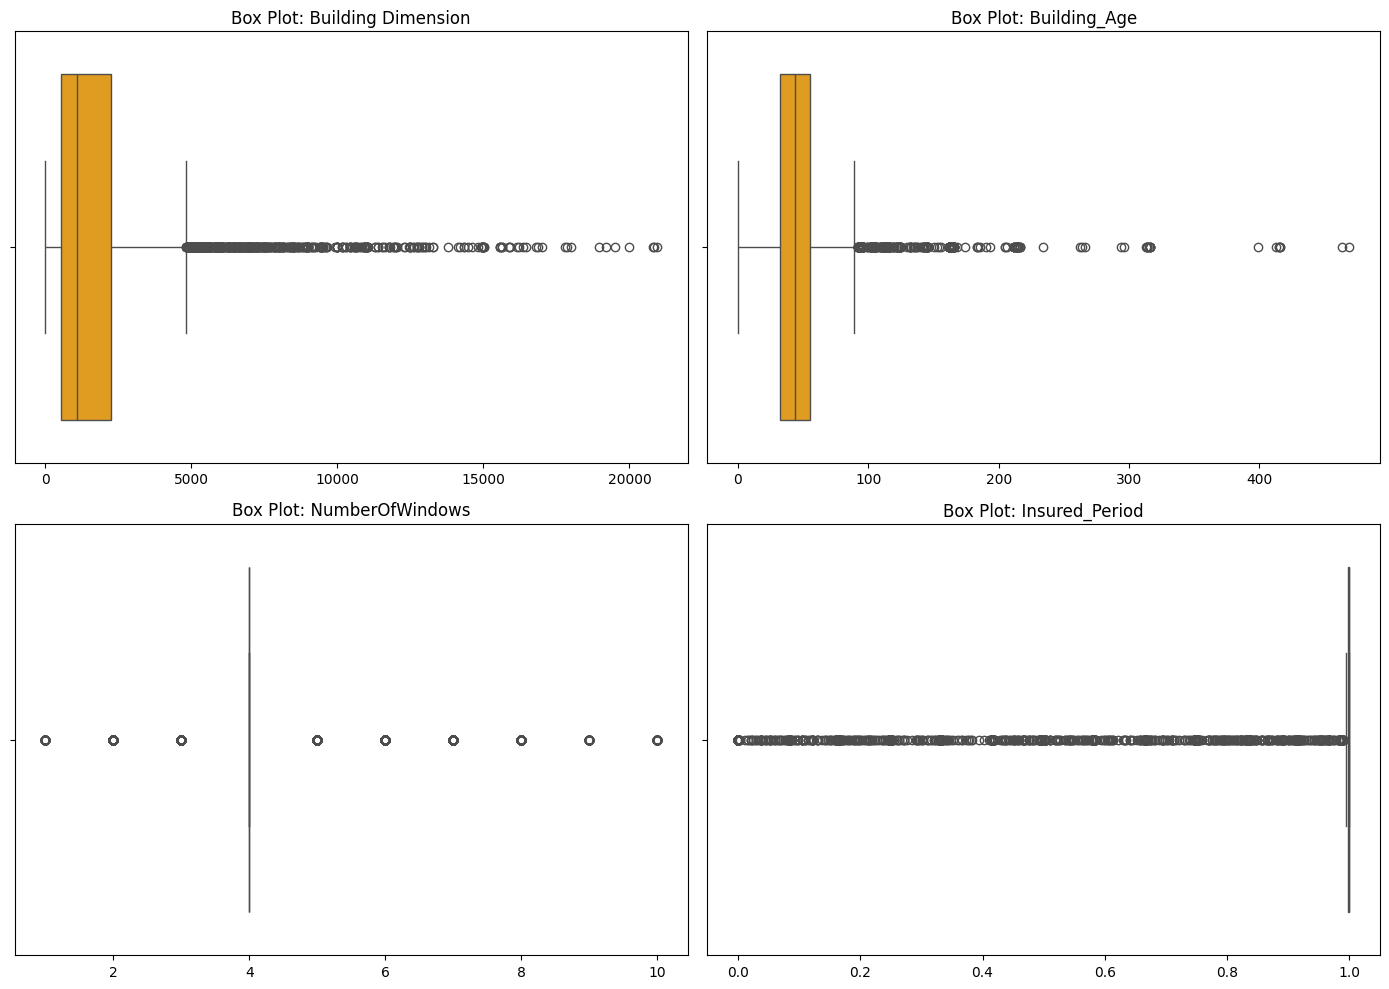

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the "True" numerical columns we care about
essential_numeric_cols = ['Building Dimension', 'Building_Age', 'NumberOfWindows', 'Insured_Period']

# Create the plot
plt.figure(figsize=(14, 10))

for i, col in enumerate(essential_numeric_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=train_df[col], color='orange')
    plt.title(f'Box Plot: {col}')
    plt.xlabel('') # Hides the label for a cleaner look

plt.tight_layout()
plt.show()

#Detecting outliers

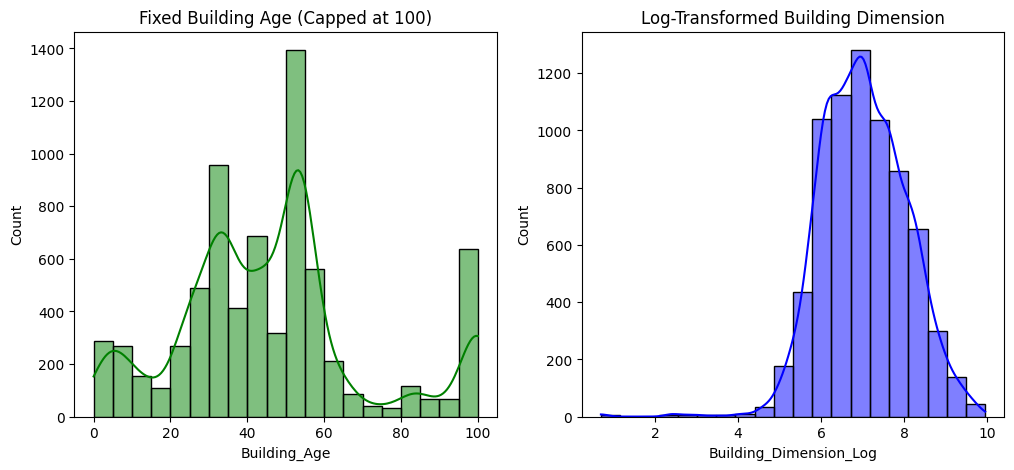

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. CAP BUILDING AGE (Handle the >400 error)
# assume any building older than 100 years is an outlier/error for this context.
# set anything > 100 to 100.
train_df.loc[train_df['Building_Age'] > 100, 'Building_Age'] = 100

# 2. LOG TRANSFORM BUILDING DIMENSION
# This shrinks the range (0 to 20,000) to a smaller scale (approx 0 to 10),
# making it easier for the model to handle.
# use np.log1p() which means log(x + 1) to avoid errors if Dimension is 0.
train_df['Building_Dimension_Log'] = np.log1p(train_df['Building Dimension'])

#  VISUALIZE THE FIX
plt.figure(figsize=(12, 5))

# Plot New Age
plt.subplot(1, 2, 1)
sns.histplot(train_df['Building_Age'], bins=20, kde=True, color='green')
plt.title('Fixed Building Age (Capped at 100)')

# Plot Log-Transformed Dimension
plt.subplot(1, 2, 2)
sns.histplot(train_df['Building_Dimension_Log'], bins=20, kde=True, color='blue')
plt.title('Log-Transformed Building Dimension')

plt.show()

# Data validtion and verification

In [18]:
#  DATA VALIDATION & VERIFICATION

print("--- 1. MISSING VALUES CHECK ---")
missing_counts = train_df.isnull().sum()
if missing_counts.sum() == 0:
    print("✅ SUCCESS: No missing values found.")
else:
    print("❌ WARNING: Missing values detected!")
    print(missing_counts[missing_counts > 0])

print("\n--- 2. LOGIC & BOUNDARY CHECK ---")
# Check Building Age
if train_df['Building_Age'].min() < 0:
    print(f"❌ ERROR: Negative Age found: {train_df['Building_Age'].min()}")
elif train_df['Building_Age'].max() > 100:
    print(f"❌ ERROR: Age above 100 found: {train_df['Building_Age'].max()}")
else:
    print("✅ SUCCESS: Building Age is within valid range (0-100).")

# Check Insured Period (Should be 0 to 1)
if train_df['Insured_Period'].max() > 1.0:
    print("❌ WARNING: Insured Period > 1.0 detected.")
else:
    print("✅ SUCCESS: Insured Period is valid.")

print("\n--- 3. INFINITY CHECK (After Log Transform) ---")
# Log of 0 can produce -inf. We used log1p so it should be fine, but let's check.
if np.isinf(train_df['Building_Dimension_Log']).sum() > 0:
    print("❌ ERROR: Infinite values found in Building_Dimension_Log.")
else:
    print("✅ SUCCESS: No infinite values in Dimension.")

print("\n--- 4. DUPLICATE CHECK ---")
duplicates = train_df.duplicated().sum()
if duplicates > 0:
    print(f"⚠️ NOTE: {duplicates} duplicate rows found. (This might be normal if IDs were dropped, but good to know).")
else:
    print("✅ SUCCESS: No duplicate rows.")

print("\n--- FINAL DATA SNAPSHOT ---")
print(train_df.info())

--- 1. MISSING VALUES CHECK ---
✅ SUCCESS: No missing values found.

--- 2. LOGIC & BOUNDARY CHECK ---
✅ SUCCESS: Building Age is within valid range (0-100).
✅ SUCCESS: Insured Period is valid.

--- 3. INFINITY CHECK (After Log Transform) ---
✅ SUCCESS: No infinite values in Dimension.

--- 4. DUPLICATE CHECK ---
⚠️ NOTE: 12 duplicate rows found. (This might be normal if IDs were dropped, but good to know).

--- FINAL DATA SNAPSHOT ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   YearOfObservation       7160 non-null   int64  
 1   Insured_Period          7160 non-null   float64
 2   Residential             7160 non-null   int64  
 3   Building_Painted        7160 non-null   object 
 4   Building_Fenced         7160 non-null   object 
 5   Garden                  7160 non-null   object 
 6   Settlement              

In [20]:
#  DATA FORMATTING

# 1. MAP BINARY COLUMNS (Text -> Numbers)
# We map 'N'/'V' to 0/1.
# We use .get() or checks to prevent errors if you ran this cell twice.
mappings = {
    'Building_Painted': {'N': 0, 'V': 1},
    'Building_Fenced': {'N': 0, 'V': 1},
    'Garden': {'O': 0, 'V': 1},
    'Settlement': {'R': 0, 'U': 1}
}

for col, mapping in mappings.items():
    if train_df[col].dtype == 'object': # Only map if it's still text
        train_df[col] = train_df[col].map(mapping)
        # Fill Garden NaNs if any created
        if col == 'Garden':
             train_df[col].fillna(train_df[col].mode()[0], inplace=True)

# 2. FORMAT GEO_CODE (Frequency Encoding)
# Check if Geo_Code exists before trying to use it
if 'Geo_Code' in train_df.columns:
    print("Encoding Geo_Code...")
    geo_counts = train_df['Geo_Code'].value_counts()
    train_df['Geo_Code_Count'] = train_df['Geo_Code'].map(geo_counts)
    train_df['Geo_Code_Count'].fillna(0, inplace=True)
else:
    print("Geo_Code already processed or missing. Skipping.")

# 3. DROP UNUSED COLUMNS (ROBUST MODE)
# We use errors='ignore' so it won't crash if Customer Id is already gone
cols_to_drop = ['Customer Id', 'Geo_Code', 'Date_of_Occupancy', 'YearOfObservation']
train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# --- FINAL CHECK ---
print("✅ Data Formatting Complete!")
print("\nFinal Column List:")
print(train_df.columns.tolist())
print("\nCheck for any 'object' columns (should be empty):")
print(train_df.select_dtypes(include=['object']).columns.tolist())

Encoding Geo_Code...
✅ Data Formatting Complete!

Final Column List:
['Insured_Period', 'Residential', 'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Building Dimension', 'Building_Type', 'NumberOfWindows', 'Claim', 'Building_Age', 'Building_Dimension_Log', 'Geo_Code_Count']

Check for any 'object' columns (should be empty):
[]


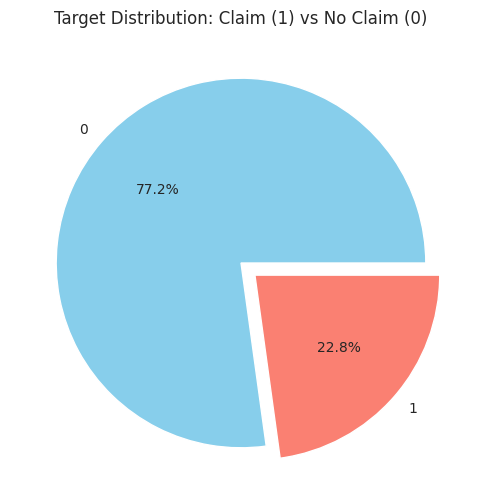

insight: The data is IMBALANCED. Only ~23% of buildings have claims.
Action: We might need to use 'class_weight=balanced' in our models.


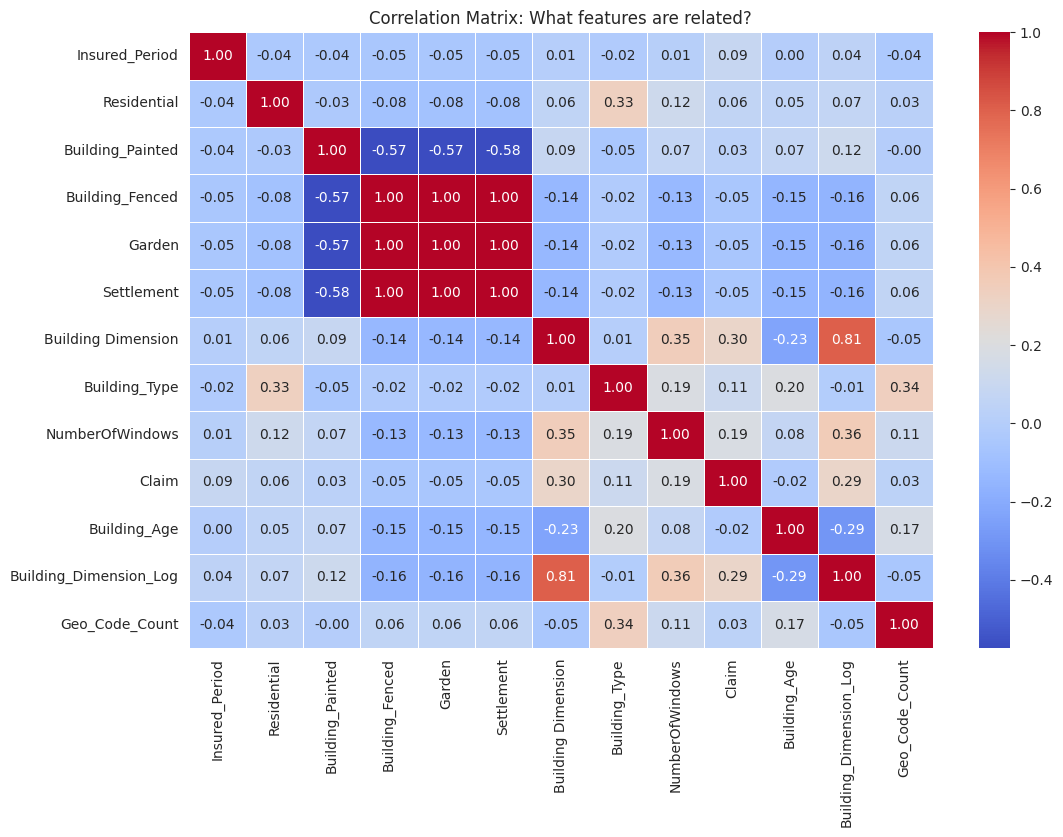

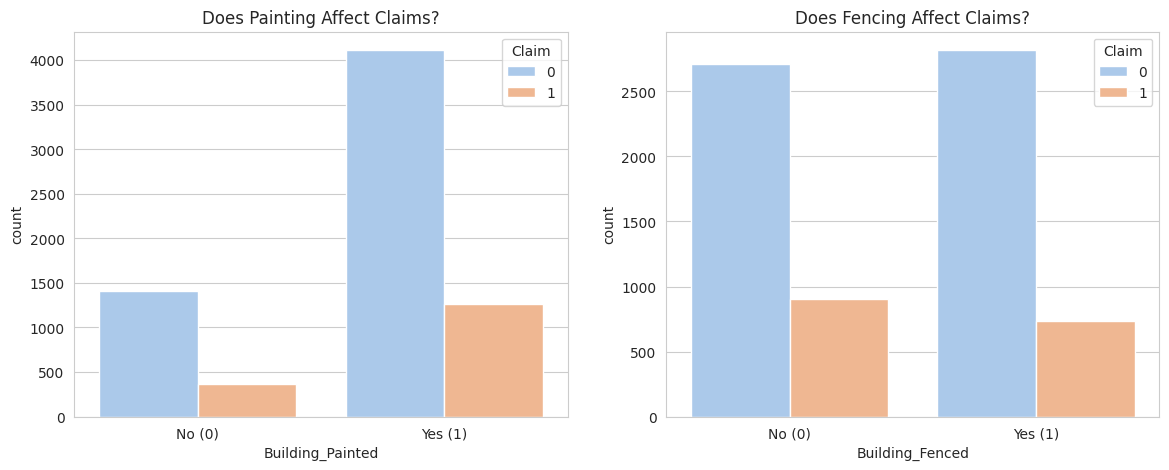

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set_style("whitegrid")

# --- CHART 1: TARGET BALANCE (The Pie Chart) ---
plt.figure(figsize=(6, 6))
train_df['Claim'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'], explode=[0, 0.1])
plt.title('Target Distribution: Claim (1) vs No Claim (0)')
plt.ylabel('') # Hides the messy 'Claim' label
plt.show()
print("insight: The data is IMBALANCED. Only ~23% of buildings have claims.")
print("Action: We might need to use 'class_weight=balanced' in our models.")

# --- CHART 2: CORRELATION HEATMAP (The Grid) ---
plt.figure(figsize=(12, 8))
# calculate correlation matrix
corr = train_df.corr()
# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: What features are related?')
plt.show()

# --- CHART 3: CATEGORICAL RISK FACTORS ---
# We want to see if Painted or Fenced buildings have more claims.
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Building_Painted vs Claim
sns.countplot(x='Building_Painted', hue='Claim', data=train_df, ax=axes[0], palette='pastel')
axes[0].set_title('Does Painting Affect Claims?')
axes[0].set_xticklabels(['No (0)', 'Yes (1)'])

# Plot Building_Fenced vs Claim
sns.countplot(x='Building_Fenced', hue='Claim', data=train_df, ax=axes[1], palette='pastel')
axes[1].set_title('Does Fencing Affect Claims?')
axes[1].set_xticklabels(['No (0)', 'Yes (1)'])

plt.show()

# Spliting and Scaling

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# DEFINE X (FEATURES) AND y (TARGET)
# X = All columns except 'Claim'
# y = Only the 'Claim' column
X = train_df.drop('Claim', axis=1)
y = train_df['Claim']

# --- 2. TRAIN-TEST SPLIT (70/30) ---
# test_size=0.3 means 30% is set aside for testing.
# stratify=y ensures both sets have the same percentage of claims (VERY IMPORTANT).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("✅ Data Split Complete!")
print(f"Training Data (70%): {X_train.shape[0]} rows")
print(f"Testing Data  (30%): {X_test.shape[0]} rows")

# --- 3. FEATURE SCALING ---
# We use StandardScaler to put all numbers on the same scale (e.g., Age vs Windows)
scaler = StandardScaler()

# Fit on Training data ONLY, then transform both.
# (This prevents 'Data Leakage' - looking at the test answers before the test)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame so we can see column names easily
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print("\n✅ Data Scaling Complete!")
print("First 5 rows of Scaled Training Data:")
print(X_train_scaled.head())

✅ Data Split Complete!
Training Data (70%): 5012 rows
Testing Data  (30%): 2148 rows

✅ Data Scaling Complete!
First 5 rows of Scaled Training Data:
   Insured_Period  Residential  Building_Painted  Building_Fenced    Garden  \
0        0.378755    -0.670993          0.570592        -0.992843 -0.992447   
1        0.378755     1.490329          0.570592        -0.992843 -0.992447   
2        0.378755    -0.670993          0.570592         1.007209  1.007611   
3       -3.135886    -0.670993          0.570592         1.007209  1.007611   
4        0.378755     1.490329          0.570592        -0.992843 -0.992447   

   Settlement  Building Dimension  Building_Type  NumberOfWindows  \
0   -0.992051            3.335702      -0.207327         3.713084   
1   -0.992051           -0.674678      -0.207327        -0.128777   
2    1.008013           -0.636467       0.851922        -0.128777   
3    1.008013           -0.629802      -0.207327        -0.128777   
4   -0.992051            0.0331

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# PREPARE DATA
# Ensure to start with the full feature set from your train_df
X = train_df.drop('Claim', axis=1)
y = train_df['Claim']

# CALCULATE FEATURE IMPORTANCE
print("Calculating Feature Importance...")
# train a temporary Random Forest just to see which columns matter
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_selector.fit(X, y)

# Create the dataframe (This fixes your error!)
feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_imp_df)

#  DROP WEAK FEATURES
# Based on the ranking, these features usually contribute < 1%
weak_features = ['Building_Fenced', 'Settlement', 'Garden']

# Double check if they exist before dropping to avoid errors
features_to_drop = [f for f in weak_features if f in X.columns]
print(f"\nDropping weak features: {features_to_drop}")

X_selected = X.drop(columns=features_to_drop)

# RE-SPLIT & RE-SCALE (With Selected Features)
# split again using only the "Strong" features
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# Scale again
scaler_sel = StandardScaler()
X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_sel.transform(X_test_sel)

# Convert back to DataFrame for readability
X_train_sel_scaled = pd.DataFrame(X_train_sel_scaled, columns=X_selected.columns)
X_test_sel_scaled = pd.DataFrame(X_test_sel_scaled, columns=X_selected.columns)

print("\n✅ Feature Selection Complete!")
print(f"Old Feature Count: {X.shape[1]}")
print(f"New Feature Count: {X_selected.shape[1]}")

Calculating Feature Importance...

Feature Importance Ranking:
                   Feature  Importance
6       Building Dimension    0.222509
10  Building_Dimension_Log    0.218549
9             Building_Age    0.185083
11          Geo_Code_Count    0.152206
0           Insured_Period    0.069799
8          NumberOfWindows    0.049473
7            Building_Type    0.049364
1              Residential    0.020932
2         Building_Painted    0.015372
4                   Garden    0.005705
5               Settlement    0.005684
3          Building_Fenced    0.005325

Dropping weak features: ['Building_Fenced', 'Settlement', 'Garden']

✅ Feature Selection Complete!
Old Feature Count: 12
New Feature Count: 9


🚀 Training the Final 3 Models on Selected Features...
Model Name                | ROC-AUC Score  
---------------------------------------------
Logistic Regression       | 0.7078
Random Forest             | 0.6571
Gradient Boosting         | 0.6973


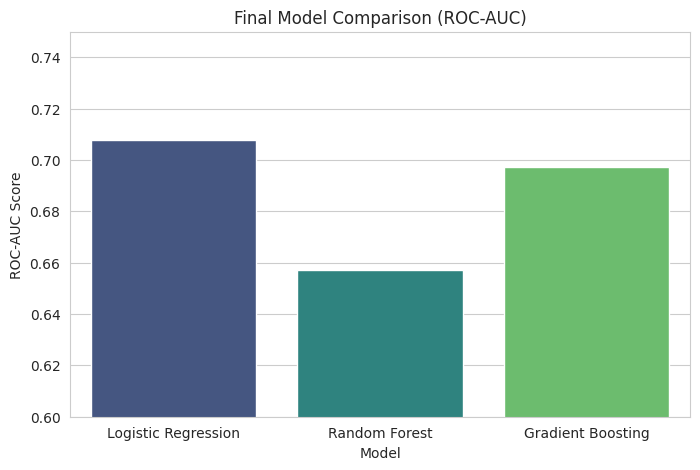


🏆 AND THE BEST IS: Logistic Regression with 0.7078 ROC-AUC!

--- Detailed Classification Report (best) ---
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      1658
           1       0.38      0.61      0.46       490

    accuracy                           0.68      2148
   macro avg       0.62      0.65      0.62      2148
weighted avg       0.75      0.68      0.70      2148



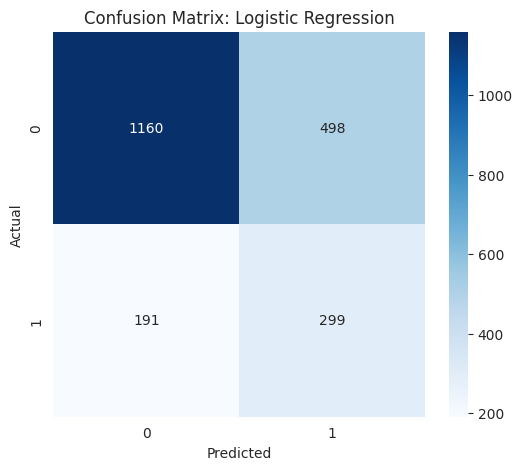

In [26]:
#  MODEL TRAINING & EVALUATION
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. DEFINE THE 3 MODELS
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

print("🚀 Training the Final 3 Models on Selected Features...")
print(f"{'Model Name':<25} | {'ROC-AUC Score':<15}")
print("-" * 45)

results = {}
best_score = 0
best_model_name = ""
best_model = None

# 2. TRAIN & EVALUATE LOOP
for name, model in models.items():
    # Train on the "Selected & Scaled" training data
    model.fit(X_train_sel_scaled, y_train)

    # Predict Probabilities (needed for ROC-AUC)
    probs = model.predict_proba(X_test_sel_scaled)[:, 1]

    # Calculate Score
    score = roc_auc_score(y_test, probs)
    results[name] = score

    # Keep track of the best
    if score > best_score:
        best_score = score
        best_model_name = name
        best_model = model

    print(f"{name:<25} | {score:.4f}")

# 3. VISUALIZE THE LEADERBOARD
plt.figure(figsize=(8, 5))
# Convert results to dataframe for easy plotting
res_df = pd.DataFrame(list(results.items()), columns=['Model', 'Score'])
sns.barplot(x='Model', y='Score', data=res_df, palette='viridis')
plt.title('Final Model Comparison (ROC-AUC)')
plt.ylim(0.60, 0.75)
plt.ylabel('ROC-AUC Score')
plt.show()

# 4. PRINT DETAILS OF THE BEST MODEL
print(f"\n🏆 AND THE BEST IS: {best_model_name} with {best_score:.4f} ROC-AUC!")
print("\n--- Detailed Classification Report (best) ---")
# Predict classes (0 or 1) for the report
y_pred = best_model.predict(X_test_sel_scaled)
print(classification_report(y_test, y_pred))

# 5. CONFUSION MATRIX OF BEST MODEL
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

🔧 Tuning Logistic Regression to find the perfect settings...

✅ Best Parameters Found: {'C': 10, 'solver': 'liblinear'}
✅ Best Cross-Val Score: 0.7250

📊 FINAL MODEL PERFORMANCE REPORT
Test Set ROC-AUC Score: 0.7080

Detailed Metrics:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79      1658
           1       0.39      0.58      0.47       490

    accuracy                           0.70      2148
   macro avg       0.62      0.66      0.63      2148
weighted avg       0.75      0.70      0.72      2148



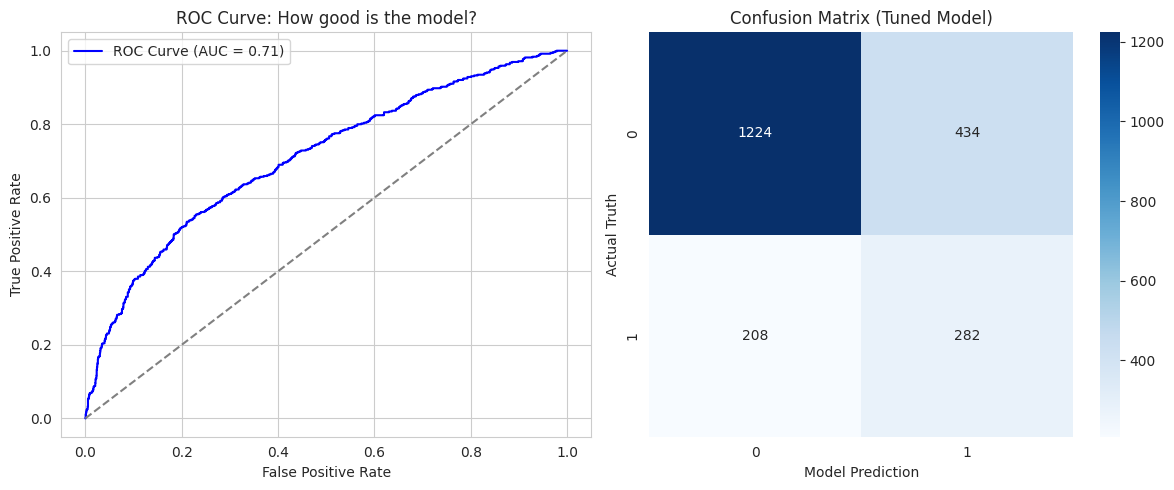

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

#  HYPERPARAMETER TUNING
print("🔧 Tuning Logistic Regression to find the perfect settings...")

# Define the "Grid" of settings to test
# 'C' is the regularization strength. Smaller = Stronger regularization.
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Run Grid Search
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
print(f"\n✅ Best Parameters Found: {grid_search.best_params_}")
print(f"✅ Best Cross-Val Score: {grid_search.best_score_:.4f}")

# FINAL EVALUATION ON TEST SET
print("\n" + "="*40)
print("📊 FINAL MODEL PERFORMANCE REPORT")
print("="*40)

# Predictions
y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

# ROC-AUC
final_score = roc_auc_score(y_test, y_prob_tuned)
print(f"Test Set ROC-AUC Score: {final_score:.4f}")

# Classification Report
print("\nDetailed Metrics:")
print(classification_report(y_test, y_pred_tuned))

# VISUALIZATION: ROC CURVE
fpr, tpr, thresholds = roc_curve(y_test, y_prob_tuned)
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {final_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: How good is the model?')
plt.legend()

# Plot Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Tuned Model)')
plt.ylabel('Actual Truth')
plt.xlabel('Model Prediction')

plt.tight_layout()
plt.show()


📊 BUSINESS INSIGHTS: WHAT DRIVES A CLAIM?
                   Feature    Impact
0           Insured_Period  0.845924
10  Building_Dimension_Log  0.326296
7            Building_Type  0.197297
3          Building_Fenced  0.108130
1              Residential  0.089683
8          NumberOfWindows  0.063530
2         Building_Painted -0.062980
4                   Garden -0.061144
5               Settlement -0.025211
9             Building_Age  0.003149
11          Geo_Code_Count  0.000996
6       Building Dimension  0.000185


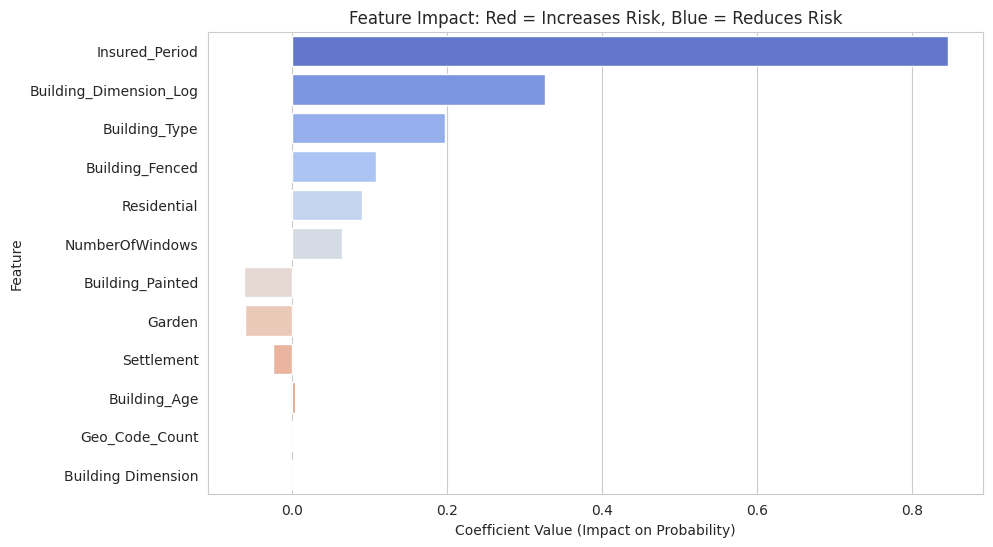


✅ SUCCESS: Model saved as 'insurance_claim_model.pkl'.


In [29]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# EXTRACT FEATURE IMPORTANCE (COEFFICIENTS)
# Logistic Regression doesn't use "Feature Importance" like trees.
# It uses "Coefficients". Positive = High Risk. Negative = Low Risk.
coefs = best_model.coef_[0]
features = X_train.columns

# Create a clear dataframe
feature_importance = pd.DataFrame({'Feature': features, 'Impact': coefs})
feature_importance['Abs_Impact'] = feature_importance['Impact'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Impact', ascending=False)

print("\n📊 BUSINESS INSIGHTS: WHAT DRIVES A CLAIM?")
print(feature_importance[['Feature', 'Impact']])

# Plot it
plt.figure(figsize=(10, 6))
#  color code: Red for Risk (Positive), Blue for Safety (Negative)
sns.barplot(x='Impact', y='Feature', data=feature_importance, palette='coolwarm')
plt.title('Feature Impact: Red = Increases Risk, Blue = Reduces Risk')
plt.xlabel('Coefficient Value (Impact on Probability)')
plt.show()

# SAVE THE MODEL FOR DEPLOYMENT
filename = 'insurance_claim_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

print(f"\n✅ SUCCESS: Model saved as '{filename}'.")